In [140]:
from pdrtpy.modelset import ModelSet
import numpy as np
from astropy.table import Table
import pdrtpy.pdrutils as utils
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy import version
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from labellines import labelLine, labelLines
from lmfit import Model, Parameters, Minimizer, minimize, fit_report
import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
m = ModelSet(name="wk2006",z=1)

In [3]:
version()

'2.1.1'

In [4]:
m.table.show_in_notebook()

idx,numerator,denominator,ratio,filename,z,title
,,,,,,null
0,OI_145,OI_63,OI_145/OI_63,oioiweb,1.0,[O I] 145 $\mu$m / [O I] 63 $\mu$m
1,OI_145,CII_158,OI_145/CII_158,o145ciiweb,1.0,[O I] 145 $\mu$m / [C II] 158 $\mu$m
2,OI_63,CII_158,OI_63/CII_158,oicpweb,1.0,[O I] 63 $\mu$m / [C II] 158 $\mu$m
3,CII_158,CI_609,CII_158/CI_609,ciici609web,1.0,[C II] 158 $\mu$m / [C I] 609 $\mu$m
4,CI_370,CI_609,CI_370/CI_609,ciciweb,1.0,[C I] 370 $\mu$m / [C I] 609 $\mu$m
5,CII_158,CO_10,CII_158/CO_10,ciicoweb,1.0,[C II] 158 $\mu$m / CO(J=1-0)
6,CII_158,CO_32,CII_158/CO_32,ciico32web,1.0,[C II] 158 $\mu$m / CO(J=3-2)
7,CII_158,CO_65,CII_158/CO_65,CII158_CO65,1.0,[C II] 158 $\mu$m / CO(J=6-5)
8,CII_158,FIR,CII_158/FIR,CII158_FIR,1.0,[C II] 158 $\mu$m / I$_{FIR}$


In [5]:
mp = ModelPlot(m)
'H264Q11/H210S1' in m.table['ratio']

Habing


True

In [6]:
try:
    m.model_ratios(["CII_158"])
except Exception as e:
    print("caught exception properly:",e)

mz = m.get_model('CII_158/CI_609')
mz.data.max()

caught exception properly: m most contain at least two strings


7066.33

[[ 9.01887035  0.39307201]
 [44.43040085 19.76740074]]
[9.01887035]
[8.60261744]
[7066.33007812]


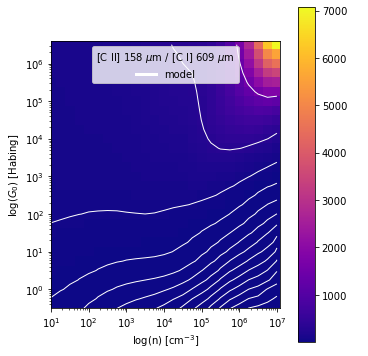

In [7]:
print(mz.get([3,1],[1,-.5],log=True))
print(mz.get(10,10**-.5,log=False))
mp.plot(mz.id)
mz.wcs
10**-.5
print(mz.get(1.1,-.45,log=True))
print(mz.get(1E7,10**6.5))
#print(mz[0,0])

In [8]:
mz.is_ratio()

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [9]:
# only residual not residual squared
def residual_single_pix(params,models,measurements):
    sum = 0.0
    parvals = params.valuesdict()
    
    mvalue = np.ones(len(models))
    dvalue = np.ones(len(measurements))
    evalue = np.ones(len(measurements))
    i=0
    for k in models:
        mvalue[i] = models[k].get(parvals['density'],parvals['radiation_field']) 
        dvalue[i] = measurements[k].value
        evalue[i] = measurements[k].error
        i = i+1
    return  (dvalue - mvalue)/evalue


In [10]:
try:
    m.get_models(['CII_158'],model_type='foo')
except ValueError as e:
    print("caught exception properly ",e)
x=m.get_models(["CI_609","FIR"],model_type="ratio")
y=m.get_models(["CI_609","FIR"],model_type="intensity")
z=m.get_models(["CI_609","FIR"],model_type="both")
q=m.get_models(['CII_158'],model_type='intensity')

caught exception properly  Unrecognized model_type: must be one of 'intensity', 'ratio', or 'both'


dict: {'CI_609': [1.5e-06] +/- 5e-07 erg / (cm2 s sr), 'CII_158/CI_609': [2] +/- 1 , 'OI_145': [3.e-06] +/- 1e-07 erg / (cm2 s sr), 'CII_158': [9.e-06] +/- 1e-06 erg / (cm2 s sr)}
<class 'pdrtpy.measurement.Measurement'>


1

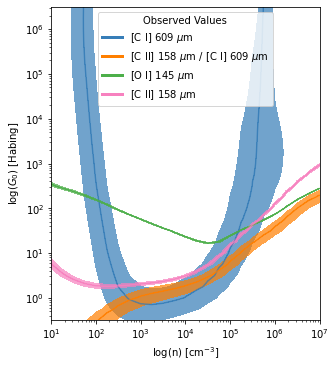

In [11]:
myunit = "erg s-1 cm-2 sr-1"
mx=Measurement(data=[1.5E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CI_609",unit=myunit)
my=Measurement(data=[2],uncertainty = StdDevUncertainty(1),identifier="CII_158/CI_609",unit=u.dimensionless_unscaled)
mz=Measurement(data=[9E-6],uncertainty = StdDevUncertainty(1E-6),identifier="CII_158",unit=myunit)
mq=Measurement(data=[3E-6],uncertainty=StdDevUncertainty(1E-7),identifier="OI_145",unit=myunit)
a=[mx,my,mq,mz]
ids = [m.id for m in a]
d = dict(zip(ids,a))
print("dict:",d)
print(type(d["CI_609"]))
#d["CI_609"].levels
mp.overlay(a,shading=.71)
len(mx.data)
#q[1].id

In [12]:
myunit = "erg s-1 cm-2 sr-1" # my default unit for value and error
m1 = Measurement(data=6E-6,uncertainty = StdDevUncertainty(1E-6),identifier="OI_145",unit=myunit)
m2 = Measurement(data=2.2E-6,uncertainty = StdDevUncertainty(5E-7),identifier="CI_609",unit=myunit)
m3 = Measurement(data=260.0,uncertainty = StdDevUncertainty(40.0),identifier="CO_21",restfreq="230.538 GHz", unit="K km/s")
m4 = Measurement(data=2E-5,uncertainty = StdDevUncertainty(2E-6),identifier="CII_158",unit=myunit)
m5 = Measurement(data=300,uncertainty=StdDevUncertainty(30),identifier="CO_43",restfreq="461.04 GHz" ,unit="K km/s")
aa = [m1,m2,m3,m4,m5]


/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:346: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


Converting K km/s to erg / (cm2 s sr) using Factor = +1.256E-08 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
Converting K km/s to erg / (cm2 s sr) using Factor = +1.256E-08 g / (cm K s2)
dict_keys(['OI_145/CII_158', 'CI_609/CO_21', 'CI_609/CO_43', 'CII_158/CI_609', 'CO_43/CO_21'])
316227.7660168379 +/- nan 1 / cm3 56.23413251903491 +/- nan Habing
Habing


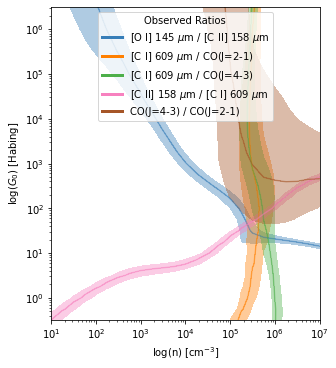

In [100]:
lrf = LineRatioFit(m,aa)
lrf.run()
print(lrf._modelratios.keys())
print(lrf.density,lrf.radiation_field)
par = Parameters()
par.add('density',min=10,max=1E7,value=1E5)
par.add('radiation_field',min=1,max=1E6,value=10)
lrp = LineRatioPlot(lrf)
lrp.overlay_all_ratios()

In [15]:
method='leastsq'
if True:
    x=residual_single_pix(par,lrf._modelratios,lrf._observedratios)
    print(x)
    len(lrf._modelratios)
    res=minimize(residual_single_pix,params=par,method=method,args=(lrf._modelratios,lrf._observedratios))
    #res2=minimize(residual_single_pix,params=par,workers=4,method='emcee',is_weighted=True,burn=300,steps=5000,args=(lrf._modelratios,lrf._observedratios))
    print(fit_report(res))
    #print(fit_report(res2))

[ 1.49335814 -2.82356136 -9.52297844  2.44345703  2.54042291]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 5
    # variables        = 2
    chi-square         = 3.96250529
    reduced chi-square = 1.32083510
    Akaike info crit   = 2.83719280
    Bayesian info crit = 2.05606863
[[Variables]]
    density:          284276.383 +/- 75299.7219 (26.49%) (init = 100000)
    radiation_field:  48.6333049 +/- 11.5285852 (23.71%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(density, radiation_field) =  0.372


In [36]:
key = utils.firstkey(lrf._observedratios)
key
np.zeros(np.insert(values=lrf.ratiocount,arr=lrf._modelshape,obj=0))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [105]:
def transform_data(lrf):
    #mvalue = np.zeros(np.insert(values=lrf.ratiocount,arr=lrf._modelshape,obj=2))
    mvalue = np.moveaxis(np.array([lrf._modelratios[k].data for k in lrf._modelratios]),source=[0],destination=[2])
    dvalue = np.array([lrf._observedratios[k].data for k in lrf._observedratios])
    evalue = np.array([lrf._observedratios[k].error for k in lrf._observedratios])
    print("shapes mde ",np.shape(mvalue),np.shape(dvalue),np.shape(evalue))
    return np.sum(((mvalue-dvalue)/evalue)**2,axis=2)
np.min(transform_data(lrf))
#print(np.array([lrf._modelratios[k].data for k in lrf._modelratios]).shape)
#print(np.shape(np.moveaxis(np.array([lrf._modelratios[k].data for k in lrf._modelratios]),source=[0],destination=[2])))
#print(lrf._modelshape)

shapes mde  (29, 25, 5) (5,) (5,)


4.49805929234543

In [106]:
# Get the input filenames of the FITS files in the testdata directory
# utils.get_testdata() is a special method to locate files there.
# These are maps from Jameson et al 2018.
print("Test FITS files are in: %s"%utils.testdata_dir())
cii_flux = utils.get_testdata("n22_cii_flux.fits")  # [C II] flux
cii_err = utils.get_testdata("n22_cii_error.fits")  # [C II] error
oi_flux = utils.get_testdata("n22_oi_flux.fits")    # [O I] flux 
oi_err = utils.get_testdata("n22_oi_error.fits")    # [O I] error
FIR_flux = utils.get_testdata("n22_FIR.fits")       # FIR flux

# Output file names
cii_combined = "n22_cii_flux_error.fits"
oi_combined = "n22_oi_flux_error.fits"
FIR_combined = "n22_FIR_flux_error.fits"

# create the Measurements and write them out as FITS files with two HDUs.
# Set overwrite=True to allow multiple runs of this notebook.
Measurement.make_measurement(cii_flux, cii_err, cii_combined,overwrite=True)
Measurement.make_measurement(oi_flux, oi_err, oi_combined,overwrite=True)
# Assign a 10% error in FIR flux
Measurement.make_measurement(FIR_flux, error='10%', outfile=FIR_combined,overwrite=True)

# Read in the FITS files to Measurements
cii_meas = Measurement.read(cii_combined, identifier="CII_158")
FIR_meas = Measurement.read(FIR_combined, identifier="FIR")
oi_meas = Measurement.read(oi_combined, identifier="OI_63")

Test FITS files are in: /home/mpound/src/pdrtpy/pdrtpy/testdata/


In [107]:
bb = [cii_meas,FIR_meas,oi_meas]
lrb = LineRatioFit(m,bb)
lrb.run()

In [108]:
np.shape(transform_data(lrf))

shapes mde  (29, 25, 5) (5,) (5,)


/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(29, 25)

In [109]:
transform_data(lrb)

shapes mde  (29, 25, 3) (3, 139, 81) (3, 139, 81)


ValueError: operands could not be broadcast together with shapes (29,25,3) (3,139,81) 

In [117]:
mvalue = np.moveaxis(np.array([lrb._modelratios[k].data for k in lrb._modelratios]),source=[0],destination=[2])
mvalue = mvalue[:,:,np.newaxis,np.newaxis]
dvalue = np.array([lrb._observedratios[k].data for k in lrb._observedratios])
evalue = np.array([lrb._observedratios[k].error for k in lrb._observedratios])
print("shapes mde ",np.shape(mvalue),np.shape(dvalue),np.shape(evalue))

shapes mde  (29, 25, 1, 1, 3) (3, 139, 81) (3, 139, 81)


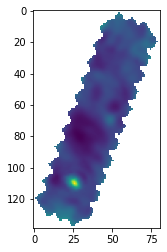

In [160]:
plt.imshow(dvalue[2])

(139, 81, 25, 29)
(139, 81)


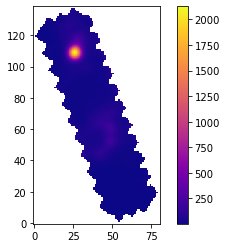

In [167]:
chisq = ((mvalue - dvalue.T)/evalue.T)**2

chi2 = np.sum(chisq,axis=4)
print(np.shape(chi2.T))
np.nanmin(chi2)
chimin = np.amin(chi2,(0,1))
print(np.shape(chimin.T))
plt.imshow(chimin.T,cmap='plasma',norm=None,origin='lower')
plt.colorbar()

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Habing


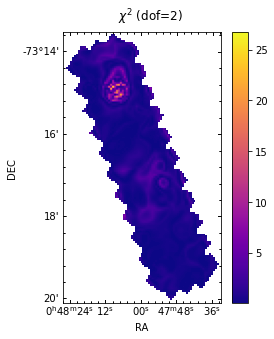

In [148]:
v = LineRatioPlot(lrb)
v.chisq(contours=False,norm=None)

In [56]:
np.array(np.insert(values=int(lrf.ratiocount),arr=lrf._observedshape,obj=len(lrf._observedshape)),dtype=np.int)
#type(lrf.ratiocount)

array([5])

In [168]:
mvalue = np.empty([11,7,np])
dvalue = np.empty([6,5,4])
evalue = np.empty([6,5,4])
np.shape(mvalue)

(11, 7)

In [ ]:
emcee_plot = corner.corner(res2.flatchain, 
                           truths=list(res2.params.valuesdict().values()),
                          show_titles=True,
                           labels=[r"$n [{\rm cm}^{-3}]$",r"$G_0$ [Habing]"],
                           title_fmt='.2e',use_math_text=True,range=[.9995,1])

In [ ]:
mp.plot("CI_609",image=True)#measurements=[mx],image=False,legend=True,contours=True,label=True)

In [ ]:
mp.plot("CI_609/FIR",image=True,measurements=[mx],legend=True,label=True)

In [ ]:
#mp.plot("CI_609/FIR",image=True,measurements=[mx,my],legend=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=False)

In [ ]:
l = LineRatioFit(m,[mx])

In [ ]:
p = LineRatioPlot(l)

In [ ]:
l.modelset.supported_ratios.show_in_notebook()

In [ ]:
p.modelintensity("CI_609",measurements=[mx],legend=True,xaxis_unit="m-3",contours=True,label=True)

In [ ]:
identifiers1 = ["OI_63+CII_158/FIR","OI_63/CII_158"]
identifiers2 = ["CO_21","OI_63"]
identifiers3 = ["CO_65","CI_609/CO_43"]

In [ ]:
mp.phasespace(identifiers2,reciprocal=[False,False],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[1,1E4]*utils._RFS_UNIT_)
#mp.savefig("OI_CO21.png",bbox_inches='tight',facecolor='white')

In [ ]:
A1 = np.array([1, 2, 2, 2, 3, 3, 7])
A2 = np.array([0.5, 1, 1.5, 2, 7, 2, 6.9])
err_bars = np.array([0.1, 0.6, 0.9, 0.2, 0.01, 0.8, 0.1])

def chisq(obs, exp, error):
    return (obs - exp) ** 2 / (error ** 2)

print(chisq(A1, A2, err_bars))

In [170]:
help(mp.overlay)

Help on method overlay in module pdrtpy.plot.modelplot:

overlay(measurements, **kwargs) method of pdrtpy.plot.modelplot.ModelPlot instance
    Overlay one or more single-pixel measurements in the model space ($n,G_0). 
    
    :param measurements: a list of one or more :class:`pdrtpy.measurement.Measurement` to overlay.
    :type measurements: list
    :param shading: Controls how measurements and errors are drawn.  If shading is zero, Measurements will be drawn in solid contour for the value and dashed for the +/- errors. If shading is between 0 and 1, Measurements are drawn with as filled contours representing the size of the errors (see :meth:`~matplotlib.pyplot.contourf`) with alpha set to the shading value.  Default value: 0.4
    :type shading: float

